In [1]:
matplotlib inline

In [2]:
"""
Plot welfare, employment, unemployment, and tax revenue as a function of the
unemployment compensation rate in the lake model.

For fixed parameters 

    alpha = job separation rate, 
    beta = discount rate, 
    gamma = job destruction rate
    w_vec, p_vec = possible wage values and their probabilities
    b, d = entry and exit rates for labor force

and a given utility function u,

"""

import numpy as np 
import matplotlib.pyplot as plt
from lake_model import LakeModel
from scipy.stats import norm
from scipy.optimize import brentq
from numba import jit

# What to do about these imports?  I'm currently using sym links...
from mccall_bellman_iteration import McCallModel  
from compute_reservation_wage import compute_reservation_wage 

# Some global variables that will stay constant

alpha  = 0.013               # monthly
alpha_q = (1-(1-alpha)**3)   # quarterly
b      = 0.0124
d      = 0.00822
beta   = 0.99                   
gamma  = 1.0

# Default utility function

sigma = 2.0
@jit
def u(c):
    if c > 0:
        return (c**(1 - sigma) - 1) / (1 - sigma)
    else:
        return -10e5
    
# The default wage distribution --- a discretized lognormal

log_wage_mean, wage_grid_size, max_wage = 20, 50, 175
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(0, max_wage, wage_grid_size + 1) # wage grid
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:]-cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1])/2

# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 135, 10)

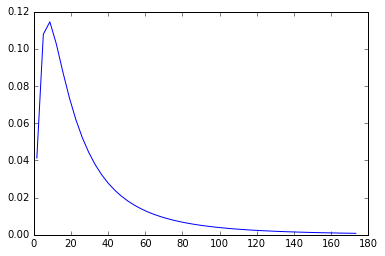

In [3]:
fig, ax = plt.subplots()
ax.plot(w_vec, p_vec)
plt.show()

In [4]:
def compute_lambda(c, T):
    """
    Compute the job finding rate given c and T by first computing the
    reservation wage from the McCall model.

    """
    
    mcm = McCallModel(alpha=alpha_q, 
                     beta=beta, 
                     gamma=gamma, 
                     c=c-T,         # post tax compensation
                     u=u, 
                     w_vec=w_vec-T, # post tax wages
                     p_vec=p_vec)

    w_bar = compute_reservation_wage(mcm)
    lmda = np.sum(p_vec[w_vec > w_bar])
    return lmda

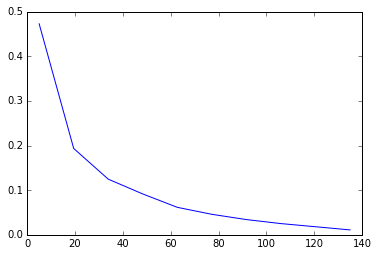

In [5]:
fig, ax = plt.subplots()
lmda_vec = []
T = 1.0
for c in c_vec:
    lmda_vec.append(compute_lambda(c, T))
ax.plot(c_vec, lmda_vec)

In [6]:
lmda_vec

[0.47261170770543987,
 0.19341362762773689,
 0.12463799444325152,
 0.091482520906454631,
 0.061517381309161241,
 0.045878059469645946,
 0.034109397884980068,
 0.025092905612064901,
 0.018076344249925071,
 0.010958267923183078]

In [7]:
def compute_steady_state_unemployment(c, T):
    """
    Compute the steady state unemployment rate given c and T using lambda, the
    job finding rate, from the McCall model and then computing steady state
    unemployment corresponding to alpha, lambda, b, d.

    """
    lmda = compute_lambda(c, T)
    lm = LakeModel(alpha=alpha, lmda=lmda, b=0, d=0) 
    x = lm.rate_steady_state()
    e, u = x
    return u

In [8]:
def find_balanced_budget_tax(c):
    """
    Find the smallest tax that will induce a balanced budget

    """
    def steady_state_budget(t):
        u_rate = compute_steady_state_unemployment(c, t)
        return t - u_rate * c

    T = brentq(steady_state_budget, 0.0, 0.9 * c)
    return T

In [9]:
find_balanced_budget_tax(70.0)

10.50000000000114

In [10]:
## Now step through all c values to be considered.  At each one, find budget
## balancing T, and then evaluate welfare, employment and unemployment at this
## pair (c, T).  Plot the values against c.

In [11]:
tax_vec = []
unempl_vec = []
empl_vec = []
for c in c_vec:
    t = find_balanced_budget_tax(c)
    u_rate = compute_steady_state_unemployment(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(1 - u_rate)

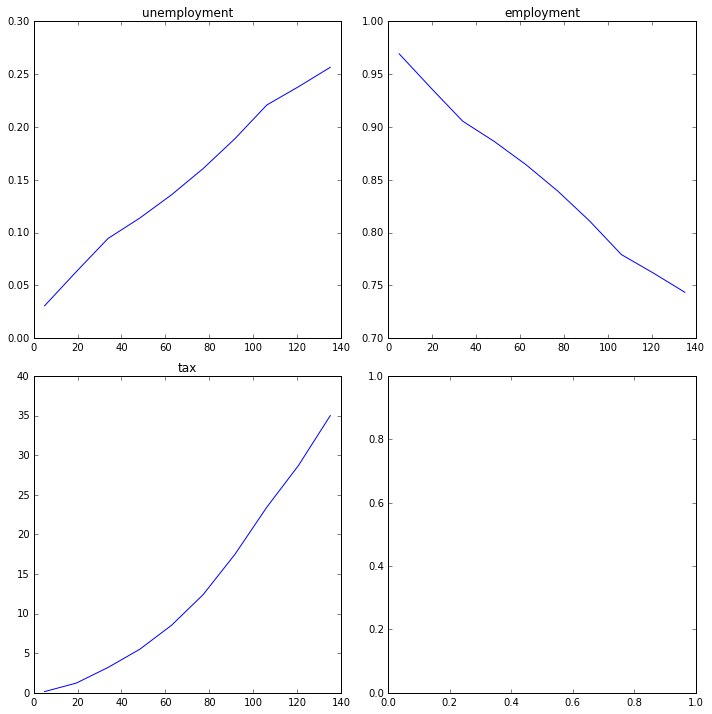

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

ax = axes[0, 0]
ax.plot(c_vec, unempl_vec)
ax.set_title('unemployment')

ax = axes[0, 1]
ax.plot(c_vec, empl_vec)
ax.set_title('employment')

ax = axes[1, 0]
ax.plot(c_vec, tax_vec)
ax.set_title('tax')

plt.tight_layout()
plt.show()